#  Corporate Procurement Contract Awards Data Analyze

The objective of this project is to analyze dataset Corporate Procurement Contract Awards available here: https://finances.worldbank.org/Procurement/Corporate-Procurement-Contract-Awards/a3d9-f9xv 

Through this post we will try to find answers to the questions:
Which are the top 10 counties that are most present in our dataset?
Which are the top 10 contracts and the country with with the  largest award amount?
Which are categories that get a larger amount of the award per contracts?
Is there any link between the supplier contract numbers and the award amount?
What are the words the most used to describe a contract?
Is there any relationship between the contract description and the award amount?

## Steps:

* Load and cleaning data
* Save of cleaned dataset
* Tokenize data
* Train model to predict project award amount
* Check model metrics



# 0. Prepare environment

In [98]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import substring,avg, col, concat,count, desc, explode, lit, min, max, split, stddev, udf, levenshtein
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, RegexTokenizer, StopWordsRemover, StringIndexer, VectorAssembler

In [2]:
import numpy as np
import string

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# create a SparkSession: note this step was left out of the screencast
spark_session = SparkSession.builder \
    .master("local") \
    .appName("Word Count") \
    .getOrCreate()

In [4]:
def load_data(filepath, spark_session = spark_session):
    """
        Load data from input paths arguments
        :param filepath: The path of data file
        :type filepath: string
        :return: The result set containing the read read from the file
        :rtype: DataFrame
    """
    data_df = spark_session.read.csv(data_path)
    data_df.persist()

    return data_df

In [5]:
def clean_data(data_df, column_subset):
    """
        Cleans and drops unused columns and duplicated lines of the dataframe passed in argument.
         :param df: The dataframe to be cleaned
         :param column_subset : subset of dataframe columns
         :type df: DataFrame
         :type column_subset: List
         :return: The result of the cleaning processing
         :rtype: DataFrame
   """

    # Drop rows having value null in the one of the columns in column_subset 
    df = data_df.dropna(how = "any", subset = column_subset)
    df = df.drop_duplicates()

    return df

# 1. Read & Explore data

Here we read input data from the file.

In [6]:
data_path = 'Corporate_Procurement_Contract_Awards.csv'

In [7]:
df = load_data(data_path)

In [8]:
df.head()

Row(_c0='Award Date', _c1='Quarter and Fiscal Year', _c2='Commodity Category', _c3='Contract Description', _c4='WBG Organization', _c5='Selection Number', _c6='Supplier', _c7='Supplier Country', _c8='Supplier Country Code', _c9='Contract Award Amount', _c10='Fund Source', _c11='VPU description')

As we see the first row is a header, so lets filter it and clean the data.

In [9]:
# Filter the header
df = df.select(df.columns).where(col("_c3")!="Contract Description")

In [10]:
df = clean_data(df,df.columns)

In [11]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)



In [12]:
# Get dataset size
df.count()

1642

In [13]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)



In [14]:
df.show(3)

+--------------------+---------+--------------------+--------------------+----+-------+--------------------+----------+---+----------+----------+--------------------+
|                 _c0|      _c1|                 _c2|                 _c3| _c4|    _c5|                 _c6|       _c7|_c8|       _c9|      _c10|                _c11|
+--------------------+---------+--------------------+--------------------+----+-------+--------------------+----------+---+----------+----------+--------------------+
|08/18/2014 12:00:...|Q1 - FY15|          CONSULTING|    Hydropower Atlas|IBRD|1130310|AECOM Concultants...|    Canada| CA| 598500.00|Trust Fund|GP- CCSA, Vice Pr...|
|07/28/2015 12:00:...|Q1 - FY16|            SOFTWARE|IBM SOFTWARE MAIN...|IBRD|15-0567|Jeskell Systems, LLC|       USA| US|2035749.37|       WBG|Information and T...|
|08/09/2018 12:00:...|Q1 - FY19|CONTRACT CONSULTANTS|Treasury and Risk...| IFC|1252950|Deloitte & Touche...|Mozambique| MZ|1045866.00|Trust Fund|IFC Chief Operati...

In [16]:
# Let's check the years covered by dataset. For this we'll use _c0='Award Date' column.
df = df.withColumn('year', substring('_c0', 7,4))
df.groupby('year').count().orderBy(desc('year')).show()

+----+-----+
|year|count|
+----+-----+
|2019|  150|
|2018|  279|
|2017|  290|
|2016|  274|
|2015|  273|
|2014|  273|
|2013|  103|
+----+-----+



So we have contract data from 2013 to 2019.

In [17]:
# Let's find the supplier contries and the number of project per country in our dataset.
# For this we will use the column _c7='Supplier Country'
country_df = df.select("_c7").groupby("_c7").count().orderBy(desc("count"))
country_df.show(10)
country_df.count()

+--------------+-----+
|           _c7|count|
+--------------+-----+
|           USA|  464|
|United Kingdom|  180|
|        France|   82|
|         India|   76|
|   Netherlands|   71|
|       Germany|   44|
|         Spain|   36|
|         Kenya|   35|
|       Denmark|   28|
|     Indonesia|   28|
+--------------+-----+
only showing top 10 rows



118

As we see the data sets covers contracts in 118 countries.
The list of top 10 countries with the highest number of contracts is displayed here.

In [18]:
country_df = df.select("_c7").groupby("_c7").count().orderBy(desc("count")).limit(10)
country_df_pd = country_df.toPandas()

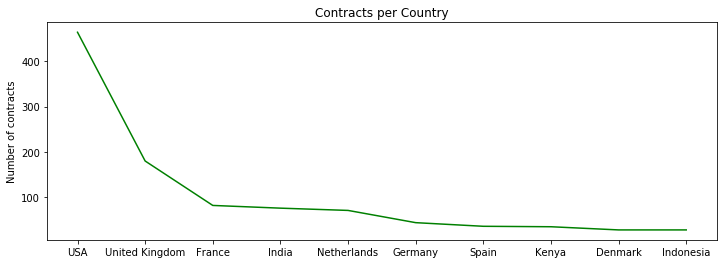

In [20]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(country_df_pd["_c7"], country_df_pd["count"], c = 'g')
ax.set(ylabel='Number of contracts',title='Contracts per Country');

In [21]:
# Before finding the total award amount per country we have to cast the type of 
# the column _c9='Contract Award Amount' from string to float.
df = df.withColumn("_c9",df["_c9"].cast(FloatType()))

In [22]:
# Let's find the total award amount per country
country_df = df.select("_c7","_c9").groupby("_c7").sum("_c9").orderBy(desc("sum(_c9)")).limit(10)
country_df.show()

+--------------+------------------+
|           _c7|          sum(_c9)|
+--------------+------------------+
|           USA|7.46312585796875E8|
|United Kingdom| 9.3354144140625E7|
|        France|  3.445774171875E7|
|   Netherlands|   3.35884134375E7|
|         India|    3.0446860875E7|
|       Germany|  1.696231778125E7|
|        Canada|   1.59528425625E7|
|         Kenya|   1.57042685625E7|
|        Brazil| 1.3171163609375E7|
|       Denmark|  1.299049553125E7|
+--------------+------------------+



Here are the top 10 countries with the corresponding award amounts. As it is said in the description of the dataset the currency is USD.

In [28]:
# let's dive in and check the contract descriptions beside the country, with largest award amount
country_df = df.select("_c3","_c7","_c9").orderBy(desc("_c9")).limit(10)
country_df.show()

+--------------------+---------+-----------+
|                 _c3|      _c7|        _c9|
+--------------------+---------+-----------+
|Food & Catering a...|      USA|     2.16E8|
|Travel Management...|      USA|     5.27E7|
|PHARMACY BENEFIT ...|      USA|      5.2E7|
|    Global Custodian|      USA|2.1941912E7|
|Somalia  Monitori...|      USA|1.2054287E7|
|Ethiopia Technica...|      USA|     1.16E7|
|Food & Catering a...|      USA|    1.125E7|
|Global Multiproto...|Mauritius|1.0871742E7|
|     GLOBAL PAYMENTS|      USA|      1.0E7|
|Global Multiproto...|      USA|  9544230.0|
+--------------------+---------+-----------+



So the highest contract awards are attributed to the contracts related to USA.

### Let's check the commodity categories: _c2='Commodity Category'

In [29]:
df.head()

Row(_c0='08/18/2014 12:00:00 AM', _c1='Q1 - FY15', _c2='CONSULTING', _c3='Hydropower Atlas', _c4='IBRD', _c5='1130310', _c6='AECOM Concultants Inc.', _c7='Canada', _c8='CA', _c9=598500.0, _c10='Trust Fund', _c11='GP- CCSA, Vice Presidency', year='2014')

In [30]:
commodity_df = df.select("_c2").groupby("_c2").count().orderBy(desc("count")).limit(10)
commodity_df.show()

+--------------------+-----+
|                 _c2|count|
+--------------------+-----+
|CONTRACT CONSULTANTS|  782|
|          CONSULTING|  630|
| CONTRACT CONSULTING|   80|
|            SOFTWARE|   44|
|EXTRNL/CATERED EVENT|   25|
|  TELECOMMUNICATIONS|   16|
|EXTERNAL/CATERED ...|   10|
| MISCELLANEOUS SRVCS|    8|
|            TRAINING|    7|
|        AUDIO VISUAL|    6|
+--------------------+-----+



[Text(0, 0.5, 'Categories'),
 Text(0.5, 0, 'Contract numbers'),
 Text(0.5, 1.0, 'Contracts per Category')]

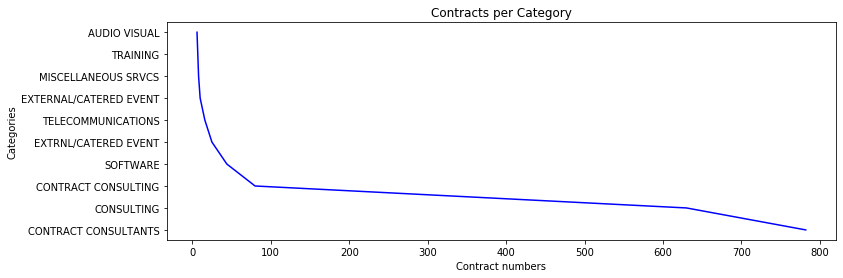

In [32]:
commodity_df_pd = commodity_df.toPandas()
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(commodity_df_pd["count"],commodity_df_pd["_c2"], c = 'b')
ax.set(xlabel = "Contract numbers", ylabel='Categories',title='Contracts per Category')

In [34]:
# let's check most expensive commodity categories 
commodity_df = df.select("_c2","_c9").groupby("_c2").sum("_c9").orderBy(desc("sum(_c9)"))
commodity_df.show(10)

+--------------------+------------------+
|                 _c2|          sum(_c9)|
+--------------------+------------------+
|CONTRACT CONSULTANTS|4.30085531859375E8|
|          CONSULTING| 3.3304275815625E8|
|        FOOD SERVICE|            2.16E8|
|             MEDICAL|           6.535E7|
| MISCELLANEOUS SRVCS| 5.6332658859375E7|
|            SOFTWARE|   5.60596633125E7|
| CONTRACT CONSULTING|    4.6378417625E7|
|  TELECOMMUNICATIONS| 3.7020390578125E7|
|EXTRNL/CATERED EVENT|    2.3154612875E7|
|        AUDIO VISUAL|      5313020.5625|
+--------------------+------------------+
only showing top 10 rows



In [35]:
# Let's dive in and find the amount of award of contracts per category of the dataset
commodity_df2 = df.select("_c2","_c9").groupby("_c2").count()
new_df = commodity_df.alias('a').join(commodity_df2.alias('b'),col('b._c2') == col('a._c2')).\
                            select([col('a.'+xx) for xx in commodity_df.columns] + [col('b.count')])
new_df.show(10)

+--------------------+------------------+-----+
|                 _c2|          sum(_c9)|count|
+--------------------+------------------+-----+
|CONTRACT CONSULTANTS|4.30085531859375E8|  782|
|          CONSULTING| 3.3304275815625E8|  630|
|        FOOD SERVICE|            2.16E8|    1|
|             MEDICAL|           6.535E7|    4|
| MISCELLANEOUS SRVCS| 5.6332658859375E7|    8|
|            SOFTWARE|   5.60596633125E7|   44|
| CONTRACT CONSULTING|    4.6378417625E7|   80|
|  TELECOMMUNICATIONS| 3.7020390578125E7|   16|
|EXTRNL/CATERED EVENT|    2.3154612875E7|   25|
|        AUDIO VISUAL|      5313020.5625|    6|
+--------------------+------------------+-----+
only showing top 10 rows



In [36]:
per_pice = udf(lambda x,y :x/y, FloatType())

In [37]:
new_df.dropna(how = "any", subset = ['sum(_c9)'])

DataFrame[_c2: string, sum(_c9): double, count: bigint]

In [38]:
new_df = new_df.withColumn('pricePerCategory',per_pice(col('sum(_c9)'), col('count'))).orderBy(desc('pricePerCategory'))
new_df.show(10)

+--------------------+-----------------+-----+----------------+
|                 _c2|         sum(_c9)|count|pricePerCategory|
+--------------------+-----------------+-----+----------------+
|        FOOD SERVICE|           2.16E8|    1|          2.16E8|
|             MEDICAL|          6.535E7|    4|       1.63375E7|
| MISCELLANEOUS SRVCS|5.6332658859375E7|    8|       7041582.5|
|  TELECOMMUNICATIONS|3.7020390578125E7|   16|       2313774.5|
|      TRANSPORTATION|      3208571.125|    2|       1604285.5|
|            SOFTWARE|  5.60596633125E7|   44|       1274083.2|
|    GENERAL BUILDING|     2021131.3125|    2|       1010565.6|
|EXTRNL/CATERED EVENT|   2.3154612875E7|   25|        926184.5|
|        AUDIO VISUAL|     5313020.5625|    6|       885503.44|
|         IT HARDWARE|     2447701.3125|    3|       815900.44|
+--------------------+-----------------+-----+----------------+
only showing top 10 rows



So even if the category 'CONTRACT CONSULTANTS' has the highest total award amount and is related to many contracts, the category with the highest award amount is 'FOOD SERVICE'.

### Let's check the biggest supplies _c6='Supplier'

In [39]:
# Who are the suppliers with max contract numbers?
supplier_df_count = df.select("_c6").groupby("_c6").count().orderBy(desc("count"))
supplier_df_count.show(10)

+--------------------+-----+
|                 _c6|count|
+--------------------+-----+
|        Castalia Ltd|   22|
|Innovations for P...|   18|
|Mott MacDonald Li...|   15|
|Oxford Policy Man...|   14|
|     NODALIS CONSEIL|   10|
|ECONOMIC CONSULTI...|   10|
|PricewaterhouseCo...|   10|
| Gide Loyrette Nouel|   10|
| Hanovia Medical Ltd|    9|
|   Ernst & Young LLP|    9|
+--------------------+-----+
only showing top 10 rows



In [40]:
# Who are the suppliers with max contract amounts?
supplier_df = df.select("_c6", "_c9").groupby("_c6").sum("_c9").orderBy(desc("sum(_c9)"))
supplier_df.show(10)

+--------------------+----------------+
|                 _c6|        sum(_c9)|
+--------------------+----------------+
|Restaurant Associ...|          2.16E8|
|          GBT US LLC|          5.62E7|
|SilverScript Insu...|           5.2E7|
|         Citibank NA|     2.1941912E7|
|          Abyrint AS|     1.5767287E7|
|Agriteam Canada C...|     1.3155993E7|
|    FLIK Hospitality|         1.125E7|
|CMC Investments I...|     1.0871742E7|
|        Castalia Ltd|1.029079309375E7|
| Citibank Europe PLC|           1.0E7|
+--------------------+----------------+
only showing top 10 rows



In [41]:
# Let's check the currelation between total award amount and contract numbers
new_supplier_df = supplier_df.alias('a').join(supplier_df_count.alias('b'),col('b._c6') == col('a._c6')).\
                            select([col('a.'+xx) for xx in supplier_df.columns] + [col('b.count')])
new_supplier_df.show(10)

+--------------------+----------------+-----+
|                 _c6|        sum(_c9)|count|
+--------------------+----------------+-----+
|Restaurant Associ...|          2.16E8|    1|
|          GBT US LLC|          5.62E7|    2|
|SilverScript Insu...|           5.2E7|    1|
|         Citibank NA|     2.1941912E7|    1|
|          Abyrint AS|     1.5767287E7|    3|
|Agriteam Canada C...|     1.3155993E7|    3|
|    FLIK Hospitality|         1.125E7|    1|
|CMC Investments I...|     1.0871742E7|    1|
|        Castalia Ltd|1.029079309375E7|   22|
| Citibank Europe PLC|           1.0E7|    1|
+--------------------+----------------+-----+
only showing top 10 rows



[Text(0, 0.5, 'Total award amount per supplier'),
 Text(0.5, 0, 'Number of contracts'),
 Text(0.5, 1.0, 'Distribution of the total contract amount vs contract count per a supplier')]

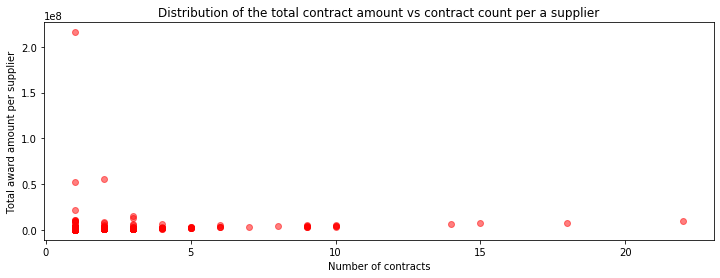

In [45]:
new_supplier_df_pd = new_supplier_df.toPandas()
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(new_supplier_df_pd["count"], new_supplier_df_pd["sum(_c9)"], c='r', alpha=0.5)
ax.set(ylabel = "Total award amount per supplier",
       xlabel = "Number of contracts",
       title = 'Distribution of the total contract amount vs contract count per a supplier')

As we see the total award amount of contracts of a supplier is not correlated with contracts' number.

Lets continue with the text analysis of the description column _c3='Contract Description'.

# 2. Text analysis

Lets continue with text analysis of the column contrat description.

In [46]:
regexTokenizer = RegexTokenizer(inputCol="_c3", outputCol="wordList")
data_df = regexTokenizer.transform(df)

In [47]:
data_df.show(3)

+--------------------+---------+--------------------+--------------------+----+-------+--------------------+----------+---+---------+----------+--------------------+----+--------------------+
|                 _c0|      _c1|                 _c2|                 _c3| _c4|    _c5|                 _c6|       _c7|_c8|      _c9|      _c10|                _c11|year|            wordList|
+--------------------+---------+--------------------+--------------------+----+-------+--------------------+----------+---+---------+----------+--------------------+----+--------------------+
|08/18/2014 12:00:...|Q1 - FY15|          CONSULTING|    Hydropower Atlas|IBRD|1130310|AECOM Concultants...|    Canada| CA| 598500.0|Trust Fund|GP- CCSA, Vice Pr...|2014| [hydropower, atlas]|
|07/28/2015 12:00:...|Q1 - FY16|            SOFTWARE|IBM SOFTWARE MAIN...|IBRD|15-0567|Jeskell Systems, LLC|       USA| US|2035749.4|       WBG|Information and T...|2015|[ibm, software, m...|
|08/09/2018 12:00:...|Q1 - FY19|CONTRACT

In [48]:
stopWordsRemover = StopWordsRemover(inputCol="wordList", outputCol="cleanWordList")
data_df = stopWordsRemover.transform(data_df)

In [49]:
get_text_length = udf(lambda x: len(x), IntegerType())

In [50]:
data_df = data_df.withColumn('DescriptionLength', get_text_length('cleanWordList'))

In [51]:
data_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: float (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- year: string (nullable = true)
 |-- wordList: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- cleanWordList: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- DescriptionLength: integer (nullable = true)



In [78]:
# Get term frequency
cv = CountVectorizer(inputCol="cleanWordList", outputCol="TF", vocabSize=1000)
cvmodel = cv.fit(data_df)
new_df = cvmodel.transform(data_df)
new_df.take(1)

[Row(_c0='08/18/2014 12:00:00 AM', _c1='Q1 - FY15', _c2='CONSULTING', _c3='Hydropower Atlas', _c4='IBRD', _c5='1130310', _c6='AECOM Concultants Inc.', _c7='Canada', _c8='CA', _c9=598500.0, _c10='Trust Fund', _c11='GP- CCSA, Vice Presidency', year='2014', wordList=['hydropower', 'atlas'], cleanWordList=['hydropower', 'atlas'], DescriptionLength=2, TF=SparseVector(1000, {221: 1.0}))]

In [105]:
# What are the top 10 words the most used to describe a contract
cvmodel.vocabulary[1:11]

['services',
 'development',
 'support',
 'program',
 'project',
 'management',
 'technical',
 'survey',
 'consultant',
 'public']

In [80]:
# Check bottom list of the term vocabylary
cvmodel.vocabulary[-10:]

['inventory',
 'rating',
 'centered',
 'privatization',
 '(isp)',
 'pumped',
 'king',
 'sava',
 '(pmeh)',
 'leaders']

In [81]:
# Get Inverce Documenr Frequency
idf = IDF(inputCol="TF", outputCol="TFIDF")
idfModel = idf.fit(new_df)
new_df = idfModel.transform(new_df)
new_df.head()

Row(_c0='08/18/2014 12:00:00 AM', _c1='Q1 - FY15', _c2='CONSULTING', _c3='Hydropower Atlas', _c4='IBRD', _c5='1130310', _c6='AECOM Concultants Inc.', _c7='Canada', _c8='CA', _c9=598500.0, _c10='Trust Fund', _c11='GP- CCSA, Vice Presidency', year='2014', wordList=['hydropower', 'atlas'], cleanWordList=['hydropower', 'atlas'], DescriptionLength=2, TF=SparseVector(1000, {221: 1.0}), TFIDF=SparseVector(1000, {221: 5.0064}))

In [83]:
assembler = VectorAssembler(inputCols=["TFIDF"], outputCol="Features")
new_df = assembler.transform(new_df)

In [84]:
new_df.head()

Row(_c0='08/18/2014 12:00:00 AM', _c1='Q1 - FY15', _c2='CONSULTING', _c3='Hydropower Atlas', _c4='IBRD', _c5='1130310', _c6='AECOM Concultants Inc.', _c7='Canada', _c8='CA', _c9=598500.0, _c10='Trust Fund', _c11='GP- CCSA, Vice Presidency', year='2014', wordList=['hydropower', 'atlas'], cleanWordList=['hydropower', 'atlas'], DescriptionLength=2, TF=SparseVector(1000, {221: 1.0}), TFIDF=SparseVector(1000, {221: 5.0064}), idx_label=373.0, Features=SparseVector(1000, {221: 5.0064}))

In [85]:
rest, validation = new_df.randomSplit([0.7, 0.3], seed = 42)

### LinearRegression

In [106]:
lr = LinearRegression(featuresCol ='Features', labelCol = '_c9', maxIter=5, regParam=0.0, fitIntercept=False, solver="normal")
lrModel = lr.fit(rest)
#lrModel.coefficients

In [107]:
lrModel.summary.r2

0.6483900167284444

In [109]:
lrPredictions = lrModel.transform(validation)

In [110]:
lrPredictions.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: float (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- year: string (nullable = true)
 |-- wordList: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- cleanWordList: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- DescriptionLength: integer (nullable = true)
 |-- TF: vector (nullable = true)
 |-- TFIDF: vector (nullable = true)
 |-- idx_label: double (nullable = false)
 |-- Features: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [111]:
lrPredictions.select("prediction","_c9","Features").show()
lrEvaluator = RegressionEvaluator(labelCol="_c9", predictionCol="prediction", metricName="rmse")
rmse = lrEvaluator.evaluate(lrPredictions)
print("Root Mean Squared Error (RMSE) on test data for linear regression = %g" % rmse)

+--------------------+---------+--------------------+
|          prediction|      _c9|            Features|
+--------------------+---------+--------------------+
| -290797.60198603506| 439921.0|(1000,[19,36,85],...|
|   5140235.828518745| 999671.0|(1000,[5,7,35,77,...|
| -1288037.6153147744|481963.34|(1000,[32,102,170...|
|1.1439009726993315E7|531296.75|(1000,[11,17,28,3...|
|   277338.5157081769| 393310.0|(1000,[14,21,41,1...|
|   455824.6088107006|360903.72|(1000,[0,7,278,32...|
|   440127.2384942813| 363411.0|(1000,[6,50,100],...|
|    84638.6229614776| 493043.0|(1000,[126],[4.51...|
|   584871.7840514984| 392120.0|(1000,[10,13,15,2...|
|  -984782.8991670524|342760.06|(1000,[10,13,15,4...|
|  202106.55295227905| 499920.0|(1000,[5,70,120,1...|
|  1818003.3578549554| 500000.0|(1000,[1,28,86],[...|
| -286324.74035095086| 270187.7|(1000,[22,30,65,8...|
|   78965.34471193032| 429350.0|(1000,[247,348,42...|
|   636847.2108542032| 651706.0|(1000,[5,9,26,155...|
|  1616184.1969578827|354885

In [118]:
lrEvaluator_r2 = RegressionEvaluator(labelCol="_c9", predictionCol="prediction", metricName="r2")
lr_r2 = lrEvaluator_r2.evaluate(lrPredictions)

In [119]:
print("R2 on test data for linear regression = %g" % lr_r2)

R2 on test data for linear regression = -0.00310965


### DecisionTreeRegressor

In [112]:
dt = DecisionTreeRegressor(featuresCol ='Features', labelCol = '_c9')
dtModel = dt.fit(rest)
dtPredictions = dtModel.transform(validation)
dtEvaluator = RegressionEvaluator(labelCol="_c9", predictionCol="prediction", metricName="rmse")
rmse = dtEvaluator.evaluate(dtPredictions)
print("Root Mean Squared Error (RMSE) on test data for decision tree = %g" % rmse)

Root Mean Squared Error (RMSE) on test data for decision tree = 9.77069e+06


In [114]:
dtPredictions.select("prediction","_c9","Features").show()

+-----------------+---------+--------------------+
|       prediction|      _c9|            Features|
+-----------------+---------+--------------------+
|572582.6692662078| 439921.0|(1000,[19,36,85],...|
|572582.6692662078| 999671.0|(1000,[5,7,35,77,...|
|572582.6692662078|481963.34|(1000,[32,102,170...|
|           1.16E7|531296.75|(1000,[11,17,28,3...|
|572582.6692662078| 393310.0|(1000,[14,21,41,1...|
|572582.6692662078|360903.72|(1000,[0,7,278,32...|
|572582.6692662078| 363411.0|(1000,[6,50,100],...|
|572582.6692662078| 493043.0|(1000,[126],[4.51...|
|572582.6692662078| 392120.0|(1000,[10,13,15,2...|
|572582.6692662078|342760.06|(1000,[10,13,15,4...|
|572582.6692662078| 499920.0|(1000,[5,70,120,1...|
|572582.6692662078| 500000.0|(1000,[1,28,86],[...|
|572582.6692662078| 270187.7|(1000,[22,30,65,8...|
|572582.6692662078| 429350.0|(1000,[247,348,42...|
|572582.6692662078| 651706.0|(1000,[5,9,26,155...|
|572582.6692662078|354885.22|(1000,[25,40,73,8...|
|572582.6692662078|275643.97|(1

In [120]:
dtEvaluator_r2 = RegressionEvaluator(labelCol="_c9", predictionCol="prediction", metricName="r2")
dt_r2 = dtEvaluator.evaluate(dtPredictions)

In [121]:
print("R2 on test data for decision tree = %g" % dt_r2)

R2 on test data for decision tree = 0.0215811


### Conclusion
After data exploration and model training we are able to answer to the last question. There is no correlation between the contract award amount and the contract description.